# UPSIT
University of Pennsylvania Smell Identification Test

In [12]:
import numpy as np
import dask.dataframe as dd
import pandas as pd
from pathlib import Path
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, accuracy_score, auc
from sklearn.metrics import roc_auc_score, confusion_matrix,ConfusionMatrixDisplay, precision_recall_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import calibration_curve
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import pearsonr

In [2]:
path=Path("/scratch/znazari/PPMI_ver_sep2022/study_data/Non-motor_Assessments/")
path2=Path("/scratch/znazari/PPMI_ver_sep2022/study_data/Archived_PPMI_Data")
path3=Path("/scratch/znazari/PPMI_ver_sep2022/study_data/Subject_Characteristics/")
path_data = Path("/home/znazari/data") # where the output data will be saved at the end.

In [3]:
upsit=pd.read_csv(path/"University_of_Pennsylvania_Smell_Identification_Test__UPSIT_.csv")

# Select rows where 'EVENT_ID' is 'BL'
upsit_bl = upsit[upsit['EVENT_ID'] == 'BL']
upsit["TOTAL_CORRECT"];

In [4]:
upsit2=pd.read_csv(path2/"University_of_Pennsylvania_Smell_ID_Test-Archived.csv")# larger dataset
upsit_bl = upsit2[upsit2["EVENT_ID"] == "BL"]
data_upsit = upsit_bl[["PATNO","UPSITBK1","UPSITBK2","UPSITBK3","UPSITBK4"]]

In [5]:
diagnosis_=pd.read_csv(path3/"Participant_Status.csv")
diagnosis = diagnosis_[["PATNO","COHORT_DEFINITION"]]

filtered_diagnosis = diagnosis[diagnosis['COHORT_DEFINITION'].isin(['Healthy Control', "Parkinson's Disease"])]

merged_df_inner = pd.merge(data_upsit, filtered_diagnosis, on='PATNO', how='inner')

merged_df_inner.to_csv(path_data/'UPSIT.csv', index=False)

df = merged_df_inner
df

,PATNO,UPSITBK1,UPSITBK2,UPSITBK3,UPSITBK4,COHORT_DEFINITION
0,3000,9.0,10.0,6.0,10.0,Healthy Control
1,3001,4.0,6.0,9.0,6.0,Parkinson's Disease
2,3002,3.0,5.0,3.0,6.0,Parkinson's Disease
3,3003,5.0,7.0,5.0,6.0,Parkinson's Disease
4,3004,10.0,10.0,8.0,8.0,Healthy Control
...,...,...,...,...,...,...
897,75480,6.0,6.0,5.0,6.0,Parkinson's Disease
898,75484,7.0,10.0,8.0,8.0,Parkinson's Disease
899,75505,6.0,9.0,6.0,7.0,Parkinson's Disease
900,75524,6.0,9.0,4.0,7.0,Parkinson's Disease


In [6]:
# To check NaN values in the dataframe
# This will return a boolean dataframe where True indicates the presence of NaN
nan_df = df.isna()

# To identify rows with NaN values
rows_with_nan = nan_df.any(axis=1)

# To identify columns with NaN values
columns_with_nan = nan_df.any(axis=0)

# Display the rows with NaN values
print("Rows with NaN values:")
print(df[rows_with_nan])

# Display the columns with NaN values
print("\nColumns with NaN values:")
print(df.columns[columns_with_nan])


Rows with NaN values:
     PATNO  UPSITBK1  UPSITBK2  UPSITBK3  UPSITBK4    COHORT_DEFINITION
244   3413       NaN       NaN       NaN       NaN  Parkinson's Disease
704  41285       NaN       NaN       NaN       NaN  Parkinson's Disease
705  41287       NaN       NaN       NaN       NaN  Parkinson's Disease
706  41288       NaN       NaN       NaN       NaN  Parkinson's Disease
707  41289       NaN       NaN       NaN       NaN  Parkinson's Disease
711  41299       8.0       6.0       NaN       NaN  Parkinson's Disease
732  41488       7.0       NaN       8.0       8.0  Parkinson's Disease
760  42293       NaN       NaN       NaN       NaN  Parkinson's Disease
776  42447       3.0       1.0       NaN       NaN  Parkinson's Disease

Columns with NaN values:
Index(['UPSITBK1', 'UPSITBK2', 'UPSITBK3', 'UPSITBK4'], dtype='object')


In [7]:
df_cleaned = df.dropna()
df = df_cleaned

In [8]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'COHORT' column
label = label_encoder.fit_transform(df['COHORT_DEFINITION'])

# Set the label for parkinson's disease and healthy control
df = df.assign(COHORT_DEFINITION=label)

In [9]:
df.set_index("PATNO", inplace=True)
df

,UPSITBK1,UPSITBK2,UPSITBK3,UPSITBK4,COHORT_DEFINITION
PATNO,,,,,
3000,9.0,10.0,6.0,10.0,0
3001,4.0,6.0,9.0,6.0,1
3002,3.0,5.0,3.0,6.0,1
3003,5.0,7.0,5.0,6.0,1
3004,10.0,10.0,8.0,8.0,0
...,...,...,...,...,...
75480,6.0,6.0,5.0,6.0,1
75484,7.0,10.0,8.0,8.0,1
75505,6.0,9.0,6.0,7.0,1


In [49]:
# Define hyperparameters 
hyperparameters = {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 60}
seed_value= 42

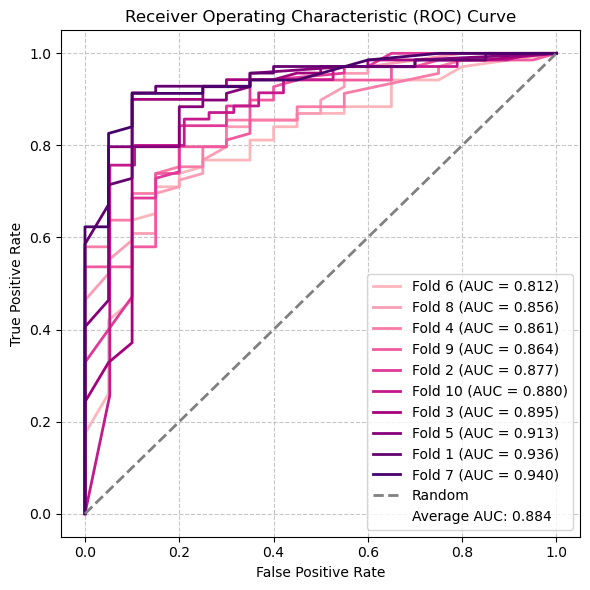

In [53]:
# Separate features (X) and target variable (y)
X = df.drop(['COHORT_DEFINITION'], axis=1)
y = df["COHORT_DEFINITION"]

# Initialize and train the XGBoost model
xgb_model = XGBClassifier(seed=seed_value, **hyperparameters)

# Perform stratified cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed_value)

# Initialize a list to store the ROC curves for each fold
roc_curve_list = []

# Initialize a list to store AUC values for each fold
auc_values = []

# Iterate through each fold
for i, (train_index, test_index) in enumerate(cv.split(X, y), start=1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    xgb_model.fit(X_train, y_train)

    # Make predictions on the testing set
    y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    
    # Calculate AUC
    auc_value = auc(fpr, tpr)
    auc_values.append(auc_value)

    # Append the ROC curve to the list
    roc_curve_list.append((fpr, tpr))

# Find the fold with the minimum and maximum AUC
min_auc_fold = np.argmin(auc_values)
max_auc_fold = np.argmax(auc_values)

# Sort folds based on AUC values
sorted_folds = sorted(enumerate(auc_values, start=1), key=lambda x: x[1])

# Create a figure with a gradient color palette
colors = plt.cm.get_cmap('RdPu')(np.linspace(0.3, 1, len(roc_curve_list)))

plt.figure(figsize=(6, 6))

# Plot ROC curve for each fold
for i, (index, auc_value) in enumerate(sorted_folds, start=1):
    color = colors[i - 1]
    plt.plot(roc_curve_list[index - 1][0], roc_curve_list[index - 1][1],
             label=f'Fold {index} (AUC = {auc_value:.3f})', color=color, linewidth=2)

# Plot the random line
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random', linewidth=2)


# Calculate average AUC
average_auc = np.mean(auc_values)

# Add average AUC to the legend
legend_handles, legend_labels = plt.gca().get_legend_handles_labels()
legend_handles.append(Line2D([0], [0], linestyle='', linewidth=0, marker=''))
legend_labels.append(f'Average AUC: {average_auc:.3f}')

# Customize plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(legend_handles, legend_labels, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [14]:
# Get the current date
current_date = datetime.now().date()

# Print the current date
print("Last update :", current_date)

Last update : 2024-03-10
